In [24]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from read_db.CH import Getch
from scipy.stats import mannwhitneyu, ttest_ind, norm
from tqdm.auto import tqdm

In [25]:
# импортируем данные за период с 08.11 по 14.11
data = Getch("select user_id, exp_group, \
countIf(action = 'view') as views, \
countIf(action = 'like') as likes, \
likes / views as ctr \
from simulator.feed_actions \
where toDate(time) >= '2021-11-08' and toDate(time) <= '2021-11-14' and \
exp_group in (2, 3) \
group by user_id, exp_group").df

In [26]:
# посмотрим на данные
data.head()

,user_id,exp_group,views,likes,ctr
0,115383,3,36,11,0.305556
1,131473,2,148,26,0.175676
2,123580,3,92,15,0.163043
3,23985,2,66,12,0.181818
4,24523,2,120,17,0.141667


### Рабочие гипотезы
- H0 - значимых статистических различий в выборках между экспериментальными группами 2 и 3 нет, система сплитования функционирует корректно;
- H1 - между выборками экспериментальных групп 2 и 3 есть статистически значимые различия, система сплитования функционирует некорректно.

In [27]:
# функция для рассчета сглаженного ctr
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [28]:
# глобальный ctr
global_ctr = data.likes.sum() / data.views.sum()
global_ctr

0.2110333174107494

In [29]:
# добавим столбец со сглаженным ctr в датасет
data['smoothed_ctr'] = data.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr, 5), axis=1)

In [30]:
data.head()

,user_id,exp_group,views,likes,ctr,smoothed_ctr
0,115383,3,36,11,0.305556,0.294028
1,131473,2,148,26,0.175676,0.176831
2,123580,3,92,15,0.163043,0.165517
3,23985,2,66,12,0.181818,0.183876
4,24523,2,120,17,0.141667,0.144441


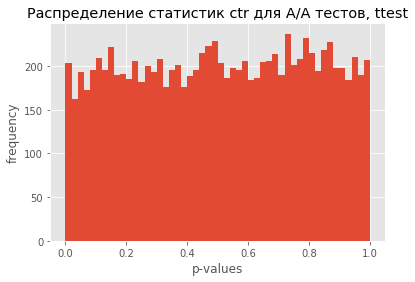

In [31]:
n = 10000 # количество симуляций aa-тестов
n_samples = 500 # количество пользователей в подвыборках
resample_ctr = []

# цикл симуляций aa-тестов для ctr
for element in tqdm(range(n)): # извлекаем подвыборки
    sample_1 = data[data.exp_group == 2].ctr.sample(n_samples, replace = False).values # вторая группа
    sample_2 = data[data.exp_group == 3].ctr.sample(n_samples, replace = False).values # третья группа
    resample_ctr.append(stats.ttest_ind(sample_1, sample_2, equal_var = False)[1]) # t-test
    
# нарисуем график
plt.hist(resample_ctr, bins = 50)
plt.style.use('ggplot')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title("Распределение статистик ctr для A/A тестов, ttest")
plt.show()

#### Значения распределены равномерно.

In [32]:
# посмотрим, какой процент p-values оказался меньше либо равен 0.05
sum(np.array(resample_ctr) <= 0.05) / n * 100

4.66

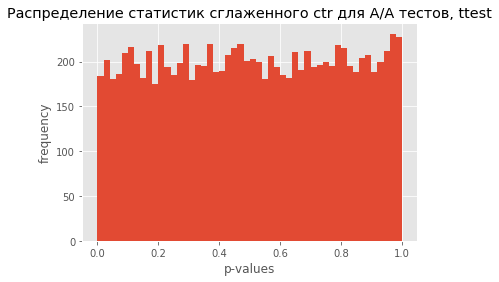

In [33]:
resample_smoothed_ctr = []

# цикл симуляций aa-тестов для сглаженного ctr
for i in tqdm(range(n)): # извлекаем подвыборки
    sample_1_1 = data[data.exp_group == 2].smoothed_ctr.sample(n_samples, replace = False).values # вторая группа
    sample_2_1 = data[data.exp_group == 3].smoothed_ctr.sample(n_samples, replace = False).values # третья группа
    resample_smoothed_ctr.append(stats.ttest_ind(sample_1_1, sample_2_1, equal_var = False)[1]) # t-test

# нарисуем график
plt.hist(resample_smoothed_ctr, bins = 50)
plt.style.use('ggplot')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title("Распределение статистик сглаженного ctr для A/A тестов, ttest")
plt.show()

#### Значения распределены равномерно.

In [35]:
# посмотрим, какой процент p-values оказался меньше либо равен 0.05
sum(np.array(resample_smoothed_ctr) <= 0.05) / n * 100

4.6899999999999995

### Вывод
- В обоих случаях (для ctr и smoothed_ctr) p-values распределены равномерно;
- Для стандартного ctr p-values оказались меньше либо равны 0.05 в 4.4 % случаев. Для сглаженного ctr p-values оказались меньше либо равны 0.05 в 4.3 % случаев. Статистически значимых различий нет ни в первом, ни во втором случае;
- Т.к не удалось установить наличие статистически значимых различий между выборками, то можно сделать вывод о том, что система сплитования функционирует корректно.
- Гипотеза H0 о равенстве выборок подтверждена, система сплитования работает корректно.